# Exercise 1

**Task:** *I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.*

In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import notebook

RANDOM_SEED = 42

First of all, we will repeat all the required steps before building the neural network: 

* Data reading 
* Vocabulary creation 
* Data split into sets.

## Reading dataset and creating mappings

In [2]:
# Opening the dataset with names and reading its content into a variable
words = open("../names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# Retrieving a set of unique letters
chars = sorted(list(set(''.join(words))))

# Creating a mapping from a letter to an id
char2id = {s: i+1 for i, s in enumerate(chars)}
# Adding the start_of_word/end_of_word token => "."
char2id['.'] = 0

# Creating a mapping from an id to letter
id2char = {i: s for s, i in char2id.items()}

vocab_size = len(id2char)

In [4]:
print(char2id)
print()
print(id2char)
print()
print(f"Vocabulary size: {vocab_size}")

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

Vocabulary size: 27


## Data split into sets

In [5]:
# Setting the random seed and reshuffling names
random.seed(RANDOM_SEED)
random.shuffle(words)

# Determining cutoff points for 10% dev and 10% test
cutoff_train = int(0.8*len(words))
cutoff_dev = int(0.9*len(words))

print(f"Training set: {0}-{cutoff_train-1:,}")
print(f"Development set: {cutoff_train:,}-{cutoff_dev-1:,}")
print(f"Testing set: {cutoff_dev:,}-{len(words)-1:,}")

print(f"\nTotal words: {len(words):,}")

Training set: 0-25,625
Development set: 25,626-28,828
Testing set: 28,829-32,032

Total words: 32,033


In [6]:
# Allocating shuffled words into three sets
words_train = words[:cutoff_train]
words_dev = words[cutoff_train:cutoff_dev]
words_test = words[cutoff_dev:]

print(f"Training set examples: {len(words_train):,} ({len(words_train)/len(words):.0%})")
print(f"Development set examples: {len(words_dev):,} ({len(words_dev)/len(words):.0%})")
print(f"Testing set examples: {len(words_test):,} ({len(words_test)/len(words):.0%})")

Training set examples: 25,626 (80%)
Development set examples: 3,203 (10%)
Testing set examples: 3,204 (10%)


In [7]:
def build_dataset(words, block_size):
    # Preallocating lists for dataset
    X, Y = [], []
    for word in words:
        # Creating a starting examples depending on block size
        context = [0] * block_size
        # Iterating through entire word with end of word token
        for char in word + '.':
            index = char2id[char]
            X.append(context)
            Y.append(index)
            # Adding the character index and shifting
            context = context[1:] + [index]
    
    # Casting as PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [8]:
# Building the datasets for three sets
X_train, Y_train = build_dataset(
    words=words_train, block_size=3,
)
X_dev, Y_dev = build_dataset(
    words=words_dev, block_size=3,
)
X_test, Y_test = build_dataset(
    words=words_test, block_size=3,
)

## Neural Network building blocks

Now we can create the key building blocks of the multilayer perceptron model:

* Linear layer
* Batch normalization layer
* Activation (tanh)

We will start with the linear layer. This time we will make use of the *Kaiming initialization* for the weights of the network (see the `__init__` method below).

In [9]:
class Linear:
    """Class for defining the linear layer."""
    
    def __init__(self, fan_in, fan_out, seed=2147483647, bias=True):
        """Initializes an instance of the linear layer class."""
        # Calibrating the random numbers generator
        generator = torch.Generator().manual_seed(seed)
        # Storing the input/output features numbers in class attributes
        self.fan_in = fan_in
        self.fan_out = fan_out
        # Initializing the weight matrix (Kaiming normal distribution initialization)
        self.weight = torch.randn((fan_in, fan_out), generator=generator) / fan_in**0.5
        # Initializing the biases
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        """Makes a forward pass."""
        # Forwarding
        self.out = x @ self.weight
        # Adding the biases if needed
        if self.bias is not None:
            self.out += self.bias
        
        return self.out
    
    def __repr__(self):
        """Prints the class representation."""
        if self.bias is None:
            return f"{self.__class__.__name__}(fan_in={self.fan_in}, fan_out={self.fan_out}, bias={False})"
        return f"{self.__class__.__name__}(fan_in={self.fan_in}, fan_out={self.fan_out}, bias={True})"
    
    def parameters(self):
        """Returns the trainable parameters."""
        
        return [self.weight] + ([] if self.bias is None else [self.bias])

Next, we will define the batch normalization layer:

In [10]:
class BatchNorm1d:
    """Class for defining the batch normalization layer."""
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        """Initializes an instance of the batch normalization layer."""
        # Dimensions
        self.dim = dim
        # Small value for preventing the perfect nullity of variance
        self.eps = eps
        # Weight of the running average
        self.momentum = momentum
        # Setting training mode
        self.training = True
        # Setting batch normalization layer parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Setting initial values of running statistics
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        """Makes a forward pass."""
        # Calculating mean and variance of the minibatch (when training)
        if self.training:
            x_mean = x.mean(0, keepdim=True) # batch mean
            x_var = x.var(0, keepdim=True) # batch variance
        # Using computed running statistics (inference mode)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        
        # Normalizing to unit variance
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        # Computing outputs of the batchnorm layer
        self.out = self.gamma * x_hat + self.beta
        
        # Updating the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        
        return self.out
    
    def __repr__(self):
        """Prints the class representation."""
        
        return f"{self.__class__.__name__}(dim={self.dim}, eps={self.eps}, momentum={self.momentum}, training={self.training})"
  
    def parameters(self):
        """Returns the trainable parameters."""
        
        return [self.gamma, self.beta]

Lastly, we will define the tanh-activation layer:

In [11]:
class Tanh:
    """Class for defining activation via tanh function."""
    
    def __call__(self, x):
        """Makes forward pass."""
        self.out = torch.tanh(x)
        
        return self.out
    
    def __repr__(self):
        """Prints the class representation."""
        
        return f"{self.__class__.__name__}()"
    
    def parameters(self):
        """Returns trainable parameters."""
        
        return []

## Building the net

Now that we have preprogrammed the key building blocks of the multiplayer perceptron model, we can finally starting putting all things together. 

1. We will use the same architecture as used in the video with biases as trainable parameters.
2. The matrix of letter embeddings `C` will have 10 dimensions so each letter is getting mapped into a 10-dimensional vector.
3. Block size will be of size 3, since in this setting we are using 3 letter to predict the next one.
4. The neural network will consist of 5 Linear layers followed by Batch Normalization layer to the outputs of which Tanh function will be applied. Lastly, the output layer will consist of a Linear layer and Batch Norm. Later, in the training loop the outputs of such a network will be passed through a Softmax layer to compute the NLL loss.

In [12]:
# Setting the dimensionality of the character embedding vectors
n_embd = 10

# Setting the number of neurons in the hidden layer of the MLP
n_hidden = 100

# Setting the block size (how many characters are used to predict the next one)
block_size = 3

# Calibrating the random numbers generator (for reproducibility)
generator = torch.Generator().manual_seed(2147483647)

# Defining the embedding matrix
C = torch.randn((vocab_size, n_embd), generator=generator)

In [13]:
# Building the neural network (stacking the layers)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, bias=True), BatchNorm1d(vocab_size),
]

# Printing the network architecture
for layer in layers:
    print(layer)
    if isinstance(layer, Tanh):
        print()

Linear(fan_in=30, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=27, bias=True)
BatchNorm1d(dim=27, eps=1e-05, momentum=0.1, training=True)


## Training the neural net

Now the network can be trained. Before answering the question at hand, we will firstly normally train the model in order to show what results are usually expected of the network and after that we will focus on the consequences of initializing weights and biases to zero.

### Normal weights initialization

In [14]:
with torch.no_grad():
    # Making the last batchnorm layer less confident
    layers[-1].gamma *= 0.1
    
    # Apply the gain to linear layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

# Combining all parameters together
parameters = [C] + [p for layer in layers for p in layer.parameters()]

# Computing the number of parameters in total
num_params = sum(p.nelement() for p in parameters)
print(f"Number of trainable parameters: {num_params:,}")

# Enabling computing gradients for all trainable parameters
for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 47,551


#### Training loop

In [15]:
# Setting number of steps
max_steps = 200_000

# Setting batch size
batch_size = 32

# Losses per step
lossi = []

# Update-to-data ratios
update2data_ratios = []

In [16]:
# Launching the training loop (with tqdm progress bar)
for i in notebook.tqdm(range(max_steps)):
  
    # Sampling minibatches on each iteration
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=generator)
    Xb, Yb = X_train[ix], Y_train[ix] 
    
    # FORWARD PASS
    #
    # Embedding the characters into vectors
    emb = C[Xb]
    # Concatenating the vectors
    x = emb.view(emb.shape[0], -1)
    # Going through all layers
    for layer in layers:
        x = layer(x)
    # Computing the loss
    loss = F.cross_entropy(x, Yb)
    
    # BACKWARD PASS
    #
    for layer in layers:
        # Retaining the gradients of layer outputs for statistics
        layer.out.retain_grad()
    # Setting all gradients to zero before doing backpropagation
    for p in parameters:
        p.grad = None
    # Initiating backpropagation
    loss.backward()
    
    # Using learning rate decay
    learning_rate = 0.1 if i < 150000 else 0.01
    # Updating weights using SGD
    for p in parameters:
        p.data -= learning_rate * p.grad
        
    # Displaying the loss every 10000 steps
    if i % 10000 == 0:
        print(f'{i}/{max_steps}: {loss.item():.4f}')
    
    # Combining the losses together
    lossi.append(loss.log10().item())
    
    # Computing update-to-data ratios
    with torch.no_grad():
        # Computing and adding ratios (log10)
        update2data_ratios.append([((learning_rate*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    # Stopping the training after 1000 iterations
    if i >= 1000:
        break

  0%|          | 0/200000 [00:00<?, ?it/s]

0/200000: 3.2980


#### Vizualizing forward pass activations

We can now vizualize the forward pass activations, namely, activations from the Tanh layer, since this activation function like other activation functions squashes the inputs between -1 and 1 so it is fairly easy to vizualize what is happening at the output of each layer. As will be shown below, we will keep track of not only mean and scale of these activations but also of the tanh saturation rates.

Layer 3 (Tanh): mean=-0.01, std=0.62, tanh_saturation=3.53%
Layer 6 (Tanh): mean=+0.01, std=0.64, tanh_saturation=2.66%
Layer 9 (Tanh): mean=+0.01, std=0.64, tanh_saturation=2.47%
Layer 12 (Tanh): mean=-0.00, std=0.65, tanh_saturation=2.19%
Layer 15 (Tanh): mean=+0.01, std=0.65, tanh_saturation=2.28%


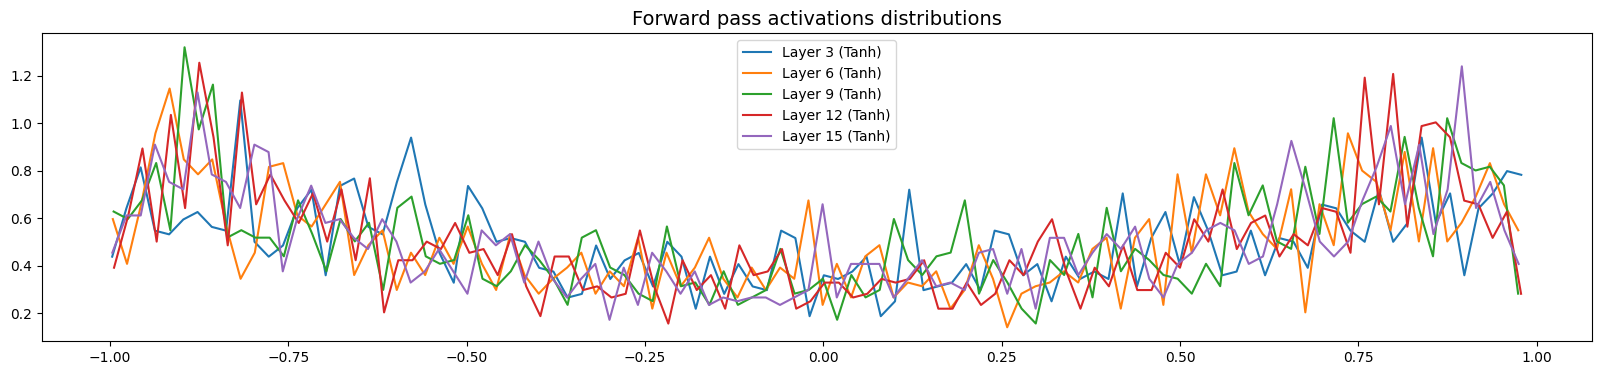

In [17]:
# Visualizing histograms of forward pass activations

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
# Iterating over all Tanh layers (except the last Softmax layer)
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        
        # Retrieving activations
        t = layer.out
        
        # Retrieving information for printing
        layer_name = layer.__class__.__name__
        t_mean = t.mean()
        t_std = t.std()
        tanh_saturation_rate = (t.abs() > 0.97).float().mean()*100
        
        # Printing activations information
        print('Layer %d (%s): mean=%+.2f, std=%.2f, tanh_saturation=%.2f%%' % (i+1, layer_name, t_mean, t_std, tanh_saturation_rate))
        
        # Building the histogram
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i+1} ({layer_name})')
              
    plt.legend(legends)
plt.title('Forward pass activations distributions', fontsize=14)
plt.show()

We can see that the saturation rates are quite stable that enables gradients to keep flowing without tanh squashing inputs to -1 or 1.

#### Vizualizing gradients

We can do the same thing for the gradients of the Tanh layer.

Layer 3 (Tanh): mean=+0.000000, std=3.561839e-03
Layer 6 (Tanh): mean=+0.000000, std=3.087499e-03
Layer 9 (Tanh): mean=-0.000000, std=2.911292e-03
Layer 12 (Tanh): mean=+0.000000, std=2.819279e-03
Layer 15 (Tanh): mean=+0.000000, std=2.580832e-03


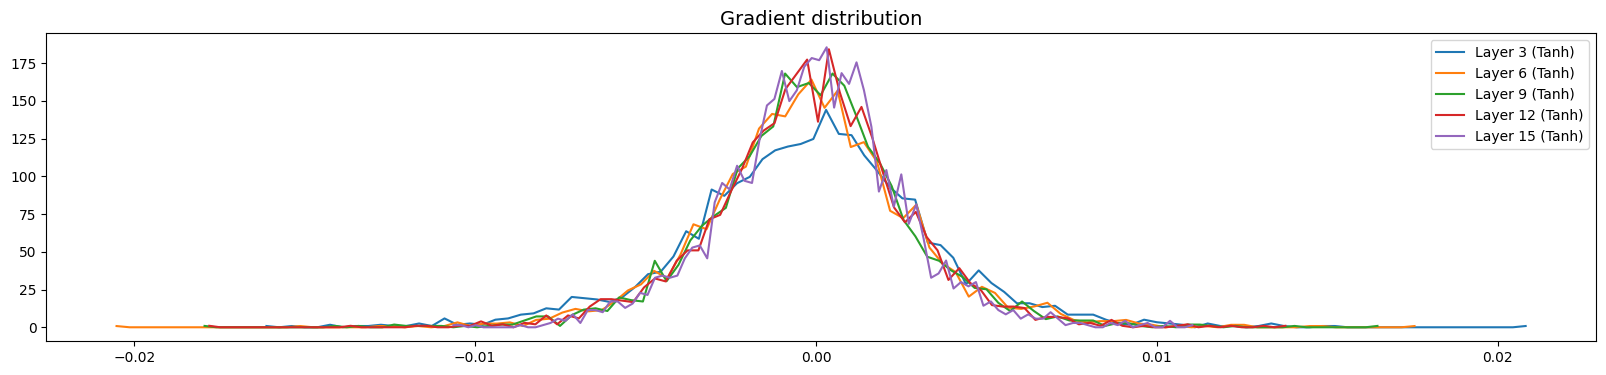

In [18]:
# Visualizing gradient histograms

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        
        # Retrieving gradients of the Tanh layer
        t = layer.out.grad
        
        # Retrieving information for printing
        layer_name = layer.__class__.__name__
        t_mean = t.mean()
        t_std = t.std()
        
        # Printing gradients information
        print('Layer %d (%s): mean=%+f, std=%e' % (i+1, layer_name, t_mean, t_std))
        
        # Building histograms
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i+1} ({layer_name})')
        
plt.legend(legends)
plt.title('Gradient distribution', fontsize=14)
plt.show()

It is observed that all layers have roughly the same gradient distribution so they are not shrinking or exploding, hence showing a good sign.

#### Vizualizing gradients of weights

It is possible to do the same thing with the gradients of weights where we can also compute the so-called *gradient-to-data* ratios which enable comparing the scale of the gradients of the parameter values to the scale of the parameter values themselves.

weight   (27, 10) | mean=+0.000000 | std=1.093979e-02 | gradient-to-data ratio=1.092812e-02
weight  (30, 100) | mean=-0.000015 | std=7.432130e-03 | gradient-to-data ratio=2.408832e-02
weight (100, 100) | mean=+0.000030 | std=6.510169e-03 | gradient-to-data ratio=3.857530e-02
weight (100, 100) | mean=-0.000004 | std=5.906775e-03 | gradient-to-data ratio=3.506960e-02
weight (100, 100) | mean=-0.000044 | std=5.438956e-03 | gradient-to-data ratio=3.231549e-02
weight (100, 100) | mean=+0.000052 | std=4.891375e-03 | gradient-to-data ratio=2.908481e-02
weight  (100, 27) | mean=-0.000083 | std=7.915652e-03 | gradient-to-data ratio=4.682348e-02


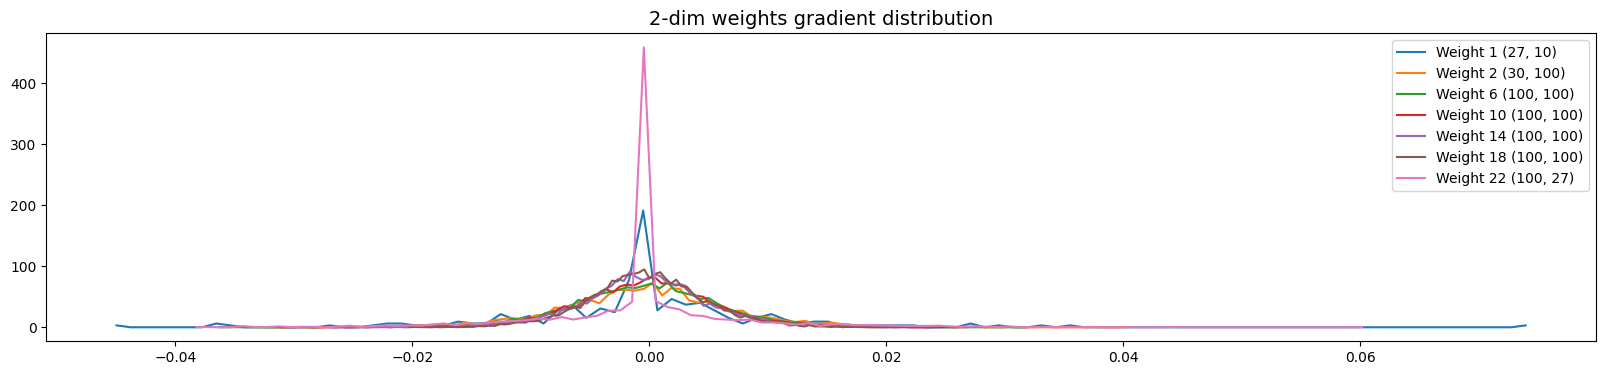

In [19]:
# Visualizing histograms of weights gradients

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    # Retrieving the weight gradient
    t = p.grad
    # Considering only 2-dimensional weights
    if p.ndim == 2:
        
        # Displaying the statistics
        print('weight %10s | mean=%+f | std=%e | gradient-to-data ratio=%e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        
        # Building the histogram
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Weight {i+1} {tuple(p.shape)}')
        
plt.legend(legends)
plt.title('2-dim weights gradient distribution', fontsize=14)
plt.show()

#### Vizualizing update-to-data ratios

The statistic *gradient-to-data* we have been using above is not in fact that informative: what we would actually like to know is how the actual update (learning rate multiplied by the gradient) relates to the the values getting updated (see calculation in the training loop above).

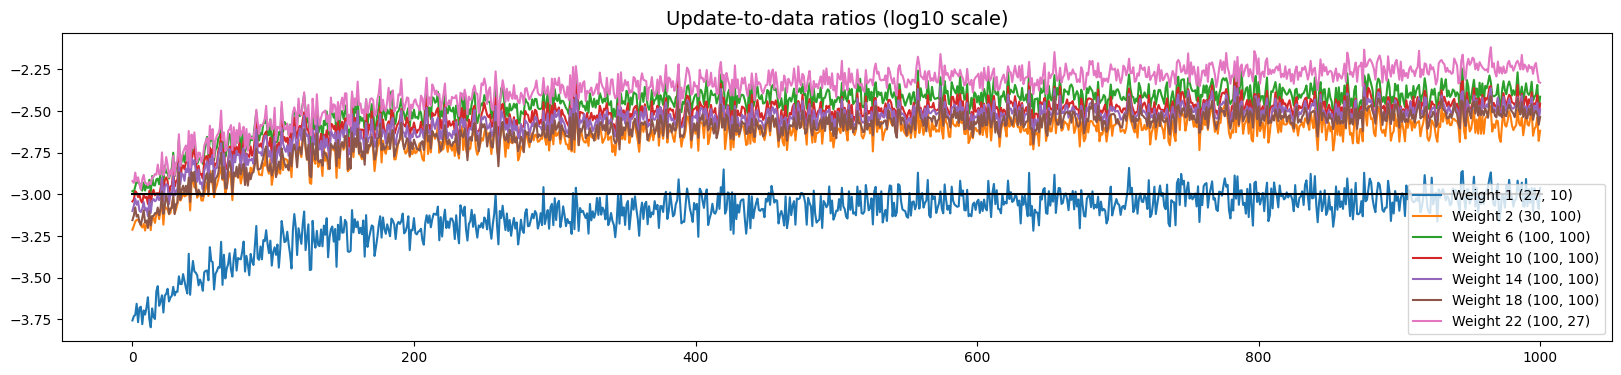

In [20]:
# Update-to-data ratios

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        
        plt.plot([update2data_ratios[j][i] for j in range(len(update2data_ratios))])
        legends.append('Weight %d %s' % ((i+1), tuple(p.shape)))

# Plotting the reference value of 10^(-3) on the log10 scale
plt.plot([0, len(update2data_ratios)], [-3, -3], 'k')
plt.legend(legends)
plt.title('Update-to-data ratios (log10 scale)', fontsize=14)
plt.show()

We can see that the training in general is going at a normal rate without any spikes. Besides, we have also set the reference value of -3 on the log10 scale, since usually the updates represent approximately $\frac{1}{1000}th$ of the parameter values.

### Initializing weights and biases to zero

Now we can run an experiment of setting all weights and biases to zero, train the network and then inspect activations and gradients.

In [21]:
# Building the neural network (stacking the layers)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, bias=True), BatchNorm1d(vocab_size),
]

# Printing the network architecture
for layer in layers:
    print(layer)
    if isinstance(layer, Tanh):
        print()

Linear(fan_in=30, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=27, bias=True)
BatchNorm1d(dim=27, eps=1e-05, momentum=0.1, training=True)


In [22]:
with torch.no_grad():
    # Setting to zero
    layers[-1].gamma *= 0.0
    
    # Setting to zero
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.0

# Combining all parameters together
parameters = [C] + [p for layer in layers for p in layer.parameters()]

# Computing the number of parameters in total
num_params = sum(p.nelement() for p in parameters)
print(f"Number of trainable parameters: {num_params:,}")

# Enabling computing gradients for all trainable parameters
for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 47,551


In [23]:
# Setting number of steps
max_steps = 200_000

# Setting batch size
batch_size = 32

# Losses per step
lossi = []

# Update-to-data ratios
update2data_ratios = []

In [24]:
# Launching the training loop (with tqdm progress bar)
for i in notebook.tqdm(range(max_steps)):
  
    # Sampling minibatches on each iteration
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=generator)
    Xb, Yb = X_train[ix], Y_train[ix] 
    
    # FORWARD PASS
    #
    # Embedding the characters into vectors
    emb = C[Xb]
    # Concatenating the vectors
    x = emb.view(emb.shape[0], -1)
    # Going through all layers
    for layer in layers:
        x = layer(x)
    # Computing the loss
    loss = F.cross_entropy(x, Yb)
    
    # BACKWARD PASS
    #
    for layer in layers:
        # Retaining the gradients of layer outputs for statistics
        layer.out.retain_grad()
    # Setting all gradients to zero before doing backpropagation
    for p in parameters:
        p.grad = None
    # Initiating backpropagation
    loss.backward()
    
    # Using learning rate decay
    learning_rate = 0.1 if i < 150000 else 0.01
    # Updating weights using SGD
    for p in parameters:
        p.data -= learning_rate * p.grad
        
    # Displaying the loss every 10000 steps
    if i % 10000 == 0:
        print(f'{i}/{max_steps}: {loss.item():.4f}')
    
    # Combining the losses together
    lossi.append(loss.log10().item())
    
    # Computing update-to-data ratios
    with torch.no_grad():
        # Computing and adding ratios (log10)
        update2data_ratios.append([((learning_rate*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    # Stopping the training after 1000 iterations
    if i >= 1000:
        break

  0%|          | 0/200000 [00:00<?, ?it/s]

0/200000: 3.2958


Layer 3 (Tanh): mean=+0.00, std=0.00, tanh_saturation=0.00%
Layer 6 (Tanh): mean=+0.00, std=0.00, tanh_saturation=0.00%
Layer 9 (Tanh): mean=+0.00, std=0.00, tanh_saturation=0.00%
Layer 12 (Tanh): mean=+0.00, std=0.00, tanh_saturation=0.00%
Layer 15 (Tanh): mean=+0.00, std=0.00, tanh_saturation=0.00%


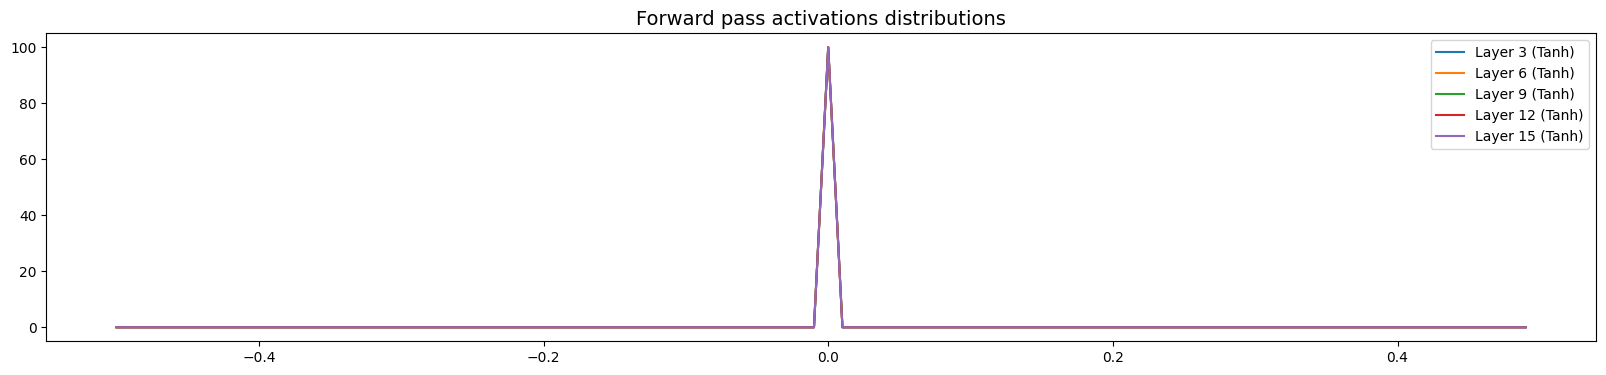

In [25]:
# Visualizing histograms of forward pass activations

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
# Iterating over all Tanh layers (except the last Softmax layer)
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        
        # Retrieving activations
        t = layer.out
        
        # Retrieving information for printing
        layer_name = layer.__class__.__name__
        t_mean = t.mean()
        t_std = t.std()
        tanh_saturation_rate = (t.abs() > 0.97).float().mean()*100
        
        # Printing activations information
        print('Layer %d (%s): mean=%+.2f, std=%.2f, tanh_saturation=%.2f%%' % (i+1, layer_name, t_mean, t_std, tanh_saturation_rate))
        
        # Building the histogram
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i+1} ({layer_name})')
              
    plt.legend(legends)
plt.title('Forward pass activations distributions', fontsize=14)
plt.show()

Layer 3 (Tanh): mean=+0.000000, std=0.000000e+00
Layer 6 (Tanh): mean=+0.000000, std=0.000000e+00
Layer 9 (Tanh): mean=+0.000000, std=0.000000e+00
Layer 12 (Tanh): mean=+0.000000, std=0.000000e+00
Layer 15 (Tanh): mean=+0.000000, std=0.000000e+00


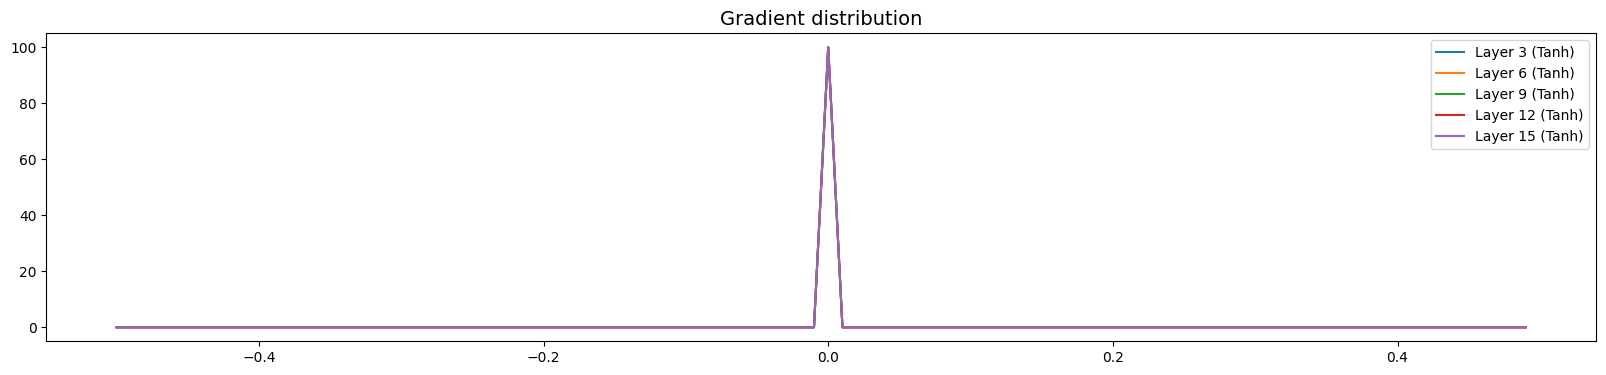

In [26]:
# Visualizing gradient histograms

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        
        # Retrieving gradients of the Tanh layer
        t = layer.out.grad
        
        # Retrieving information for printing
        layer_name = layer.__class__.__name__
        t_mean = t.mean()
        t_std = t.std()
        
        # Printing gradients information
        print('Layer %d (%s): mean=%+f, std=%e' % (i+1, layer_name, t_mean, t_std))
        
        # Building histograms
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i+1} ({layer_name})')
        
plt.legend(legends)
plt.title('Gradient distribution', fontsize=14)
plt.show()

weight   (27, 10) | mean=+0.000000 | std=0.000000e+00 | gradient-to-data ratio=0.000000e+00
weight  (30, 100) | mean=+0.000000 | std=0.000000e+00 | gradient-to-data ratio=nan
weight (100, 100) | mean=+0.000000 | std=0.000000e+00 | gradient-to-data ratio=nan
weight (100, 100) | mean=+0.000000 | std=0.000000e+00 | gradient-to-data ratio=nan
weight (100, 100) | mean=+0.000000 | std=0.000000e+00 | gradient-to-data ratio=nan
weight (100, 100) | mean=+0.000000 | std=0.000000e+00 | gradient-to-data ratio=nan
weight  (100, 27) | mean=+0.000000 | std=0.000000e+00 | gradient-to-data ratio=nan


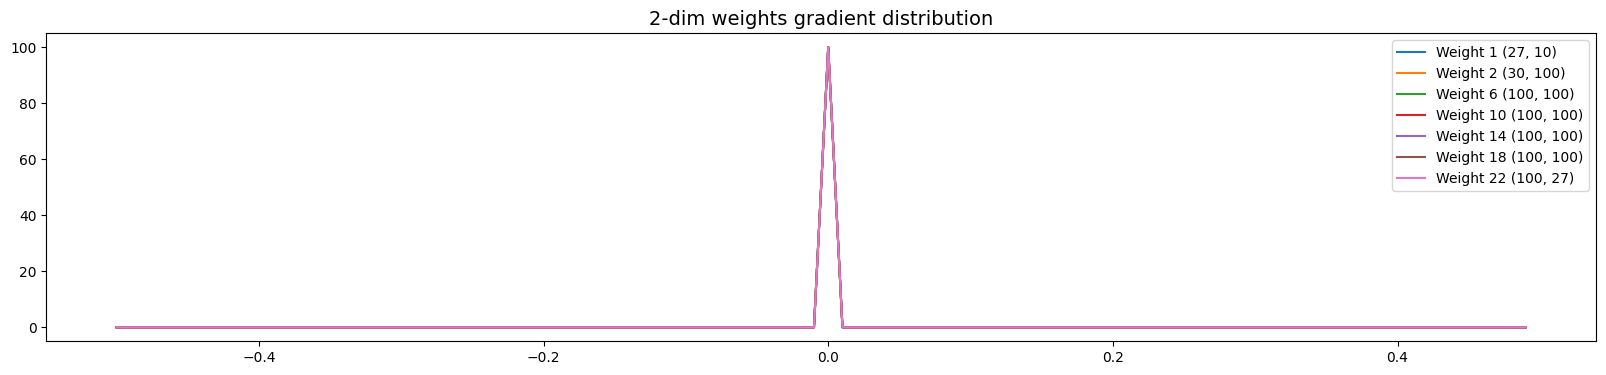

In [27]:
# Visualizing histograms of weights gradients

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    # Retrieving the weight gradient
    t = p.grad
    # Considering only 2-dimensional weights
    if p.ndim == 2:
        
        # Displaying the statistics
        print('weight %10s | mean=%+f | std=%e | gradient-to-data ratio=%e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        
        # Building the histogram
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Weight {i+1} {tuple(p.shape)}')
        
plt.legend(legends)
plt.title('2-dim weights gradient distribution', fontsize=14)
plt.show()

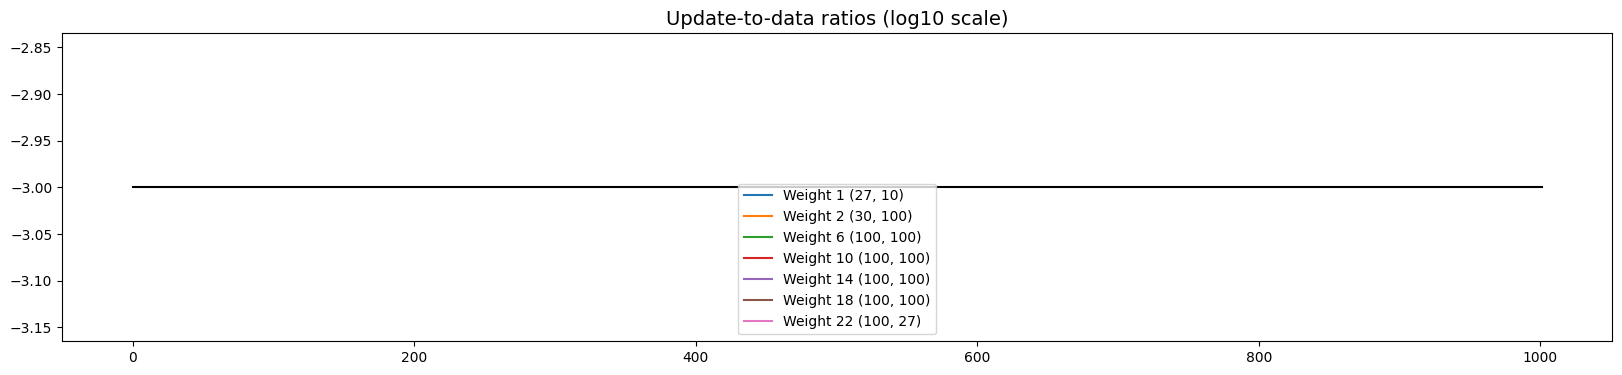

In [28]:
# Update-to-data ratios

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        
        plt.plot([update2data_ratios[j][i] for j in range(len(update2data_ratios))])
        legends.append('Weight %d %s' % ((i+1), tuple(p.shape)))

# Plotting the reference value of 10^(-3) on the log10 scale
plt.plot([0, len(update2data_ratios)], [-3, -3], 'k')
plt.legend(legends)
plt.title('Update-to-data ratios (log10 scale)', fontsize=14)
plt.show()

# Exercise 2

**Task:** *BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.*

## Training 3-layer MLP with BatchNorms

In [29]:
# Setting the dimensionality of the character embedding vectors
n_embd = 10

# Setting the number of neurons in the hidden layer of the MLP
n_hidden = 100

# Setting the block size (how many characters are used to predict the next one)
block_size = 3

# Calibrating the random numbers generator (for reproducibility)
generator = torch.Generator().manual_seed(2147483647)

# Defining the embedding matrix
C = torch.randn((vocab_size, n_embd), generator=generator)

In [30]:
layers = [
  Linear(n_embd * block_size, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, bias=True), BatchNorm1d(vocab_size),
]

# Printing the network architecture
for layer in layers:
    print(layer)
    if isinstance(layer, Tanh):
        print()

Linear(fan_in=30, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=100, bias=True)
BatchNorm1d(dim=100, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=100, fan_out=27, bias=True)
BatchNorm1d(dim=27, eps=1e-05, momentum=0.1, training=True)


In [31]:
with torch.no_grad():
    # Making the last batchnorm layer less confident
    layers[-1].gamma *= 0.1
    
    # Apply the gain to linear layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

# Combining all parameters together
parameters = [C] + [p for layer in layers for p in layer.parameters()]

# Computing the number of parameters in total
num_params = sum(p.nelement() for p in parameters)
print(f"Number of trainable parameters: {num_params:,}")

# Enabling computing gradients for all trainable parameters
for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 26,951


In [32]:
# Setting number of steps
max_steps = 200_000

# Setting batch size
batch_size = 32

# Losses per step
lossi = []

# Update-to-data ratios
update2data_ratios = []

In [33]:
# Launching the training loop (with tqdm progress bar)
for i in notebook.tqdm(range(max_steps)):
  
    # Sampling minibatches on each iteration
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=generator)
    Xb, Yb = X_train[ix], Y_train[ix] 
    
    # FORWARD PASS
    #
    # Embedding the characters into vectors
    emb = C[Xb]
    # Concatenating the vectors
    x = emb.view(emb.shape[0], -1)
    # Going through all layers
    for layer in layers:
        x = layer(x)
    # Computing the loss
    loss = F.cross_entropy(x, Yb)
    
    # BACKWARD PASS
    #
    for layer in layers:
        # Retaining the gradients of layer outputs for statistics
        layer.out.retain_grad()
    # Setting all gradients to zero before doing backpropagation
    for p in parameters:
        p.grad = None
    # Initiating backpropagation
    loss.backward()
    
    # Using learning rate decay
    learning_rate = 0.1 if i < 150000 else 0.01
    # Updating weights using SGD
    for p in parameters:
        p.data -= learning_rate * p.grad
        
    # Displaying the loss every 10000 steps
    if i % 10000 == 0:
        print(f'{i}/{max_steps}: {loss.item():.4f}')
    
    # Combining the losses together
    lossi.append(loss.log10().item())
    
    # Computing update-to-data ratios
    with torch.no_grad():
        # Computing and adding ratios (log10)
        update2data_ratios.append([((learning_rate*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    # Stopping the training after 1000 iterations
    if i >= 1000:
        break

  0%|          | 0/200000 [00:00<?, ?it/s]

0/200000: 3.3052


## Evaluating using BatchNorm

In [34]:
@torch.no_grad()
def compute_loss(split):
    """Computes loss for a split (passing all layers)."""
    
    # Putting all data splits together
    x, y = {
      'train': (X_train, Y_train),
      'val': (X_dev, Y_dev),
      'test': (X_test, Y_test),
    }[split]
    
    # Mapping letters to embeddings (shape=(N, block_size, n_embd))
    emb = C[x]
    
    # Concatenating embeddings to another matrix (shape=(N, block_size * n_embd))
    x = emb.view(emb.shape[0], -1)
    
    # Going through each layer
    for layer in layers:
        x = layer(x)
    
    # Computing the loss
    loss = F.cross_entropy(x, y)
    
    print(f"{split}_loss={loss.item():.4f}")

In [35]:
# Enabling evaluation mode
for layer in layers:
    layer.training = False

In [36]:
%%time

# Computing losses
compute_loss(split='train')
compute_loss(split='val')

train_loss=2.4557
val_loss=2.4540
CPU times: total: 3.09 s
Wall time: 773 ms


## Evaluation using folding

It is actually possible to optimize the inferencing by using the so-called "folding", where we can "fold in" weights of the batch normalization layer into the weights of the preceding linear layer, thus bypassing the batchnorm layer when making a forward pass. Such an operation should save some time when running the model in the evaluation mode.

Firstly, consider the outputs of the linear and batchnorm layers:

$$Linear: z = W  x + b$$

$$BatchNorm: out = \gamma \frac{z - \mu}{\sqrt{\sigma^{2} + \epsilon}} + \beta$$

Now, if we keep adjusting (for each linear layer encountered) the weight matrix `W` and bias vector `b` to include the parameters $\gamma$ and $\beta$ of the following batchnorm layer, we can skip the batchnorm layer and still achieve the same results.

We will consider two possible situations:

* Applying the bias
* Removing the bias

### Applying the bias

In order to compose the appropriate weight matrix, we can just plug the linear layer outputs into the equation for the batchnorm outputs:

$$out = \gamma \frac{(Wx + b) - \mu}{\sqrt{\sigma^{2} + \epsilon}} + \beta$$

$$out = \gamma \frac{Wx + b - \mu}{\sqrt{\sigma^{2} + \epsilon}} + \beta$$

$$\Downarrow$$

$$out = \left(\gamma \frac{W}{\sqrt{\sigma^{2} + \epsilon}}\right)x + \left(\gamma \frac{b - \mu}{\sqrt{\sigma^{2} + \epsilon}} + \beta\right)$$

$$out = W_{fold} * x + b_{fold}$$

### Without bias

We can do the same calculations for the situation when we do not have the bias. In this case we can just use the previously obtained equation and just substitute $b$ for zero:

$$out = \left(\gamma \frac{W}{\sqrt{\sigma^{2} + \epsilon}}\right)x + \gamma \frac{0-\mu}{\sqrt{\sigma^{2} + \epsilon}} + \beta$$

$$out = \left(\gamma \frac{W}{\sqrt{\sigma^{2} + \epsilon}}\right)x - \gamma \frac{\mu}{\sqrt{\sigma^{2} + \epsilon}} + \beta$$

$$\Downarrow$$

$$out = \left(\gamma \frac{W}{\sqrt{\sigma^{2} + \epsilon}}\right)x + \left(\beta - \gamma \frac{\mu}{\sqrt{\sigma^{2} + \epsilon}}\right)$$

$$out = W_{fold} * x + b_{fold}$$

### Verification of computations

In [37]:
@torch.no_grad()
def compute_loss_fold(split):
    """Computes loss for a split (folding)."""
    
    x, y = {
      'train': (X_train, Y_train),
      'val': (X_dev, Y_dev),
      'test': (X_test, Y_test),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    
    # Going through all layers (with folding into Linear layer)
    for layer in layers:
        
        # Selecting weight and bias (Linear layer)
        if isinstance(layer, Linear):
            W = layer.weight
            bias = layer.bias
            
        # Selecting parameters (BatchNorm layer)
        elif isinstance(layer, BatchNorm1d):
            gamma = layer.gamma
            beta = layer.beta
            mean = layer.running_mean
            var = layer.running_var
            eps = layer.eps
            
            # Running computations for the last BatchNorm layer
            if layer is layers[-1]:
                
                # Computing new W_fold
                W_fold = gamma * W / torch.sqrt(var + eps)
                # Computing new b_fold
                if bias is not None:
                    b_fold = beta + gamma * (bias - mean) / torch.sqrt(var + eps)
                else:
                    b_fold = beta - gamma * mean / torch.sqrt(var + eps)
                
                # Computing inputs to Softmax()
                x = x @ W_fold + b_fold
        
        # Computing activations
        else:
            # Computing new W_fold
            W_fold = gamma * W / torch.sqrt(var + eps)
            # Computing new b_fold (depending on the bias)
            if bias is not None:
                b_fold = beta + gamma * (bias - mean) / torch.sqrt(var + eps)
            else:
                b_fold = beta - gamma * mean / torch.sqrt(var + eps)
            
            # Computing inputs to Tanh() using Linear layer
            x = x @ W_fold + b_fold
            # Activation via Tanh()
            x = layer(x)
    
    loss = F.cross_entropy(x, y)
    print(f"{split}_loss={loss.item():.4f}")

In [38]:
%%time
    
# Computing losses
compute_loss_fold(split='train')
compute_loss_fold(split='val')

train_loss=2.4557
val_loss=2.4540
CPU times: total: 1.92 s
Wall time: 486 ms


It can be seen that we have managed to obtain the same results but at a higher speed.